In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
# Load the dataset
import tarfile
import os

# Extract dataset
if not os.path.exists("aclImdb"):
    tar = tarfile.open("aclImdb_v1.tar.gz", "r:gz")
    tar.extractall()
    tar.close()

# Load positive and negative reviews
def load_imdb_data(data_dir):
    data = []
    labels = []
    for label in ["pos", "neg"]:
        path = os.path.join(data_dir, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                data.append(f.read())
                labels.append(1 if label == "pos" else 0)
    return data, labels

data, labels = load_imdb_data("aclImdb/train")
test_data, test_labels = load_imdb_data("aclImdb/test")

df = pd.DataFrame({"review": data, "sentiment": labels})
test_df = pd.DataFrame({"review": test_data, "sentiment": test_labels})

print(df.head())


C:\Users\alvin\AppData\Local\Temp\ipykernel_56072\641607424.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


                                              review  sentiment
0  Bromwell High is a cartoon comedy. It ran at t...          1
1  Homelessness (or Houselessness as George Carli...          1
2  Brilliant over-acting by Lesley Ann Warren. Be...          1
3  This is easily the most underrated film inn th...          1
4  This is not the typical Mel Brooks film. It wa...          1


In [6]:
# Remove stopwords and lowercase
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_review'] = df['review'].apply(preprocess_text)
test_df['clean_review'] = test_df['review'].apply(preprocess_text)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


In [8]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Evaluate
y_pred = model.predict(X_val_vec)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.851
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      2485
           1       0.85      0.85      0.85      2515

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [12]:
import streamlit as st
from transformers import pipeline

# Initialize the BERT pipeline
bert_pipeline = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,  # Automatically truncate inputs longer than 512 tokens
    max_length=512    # Explicitly set maximum token length
)

# Streamlit App
st.title("Sentiment Analysis App")

# User Input
user_input = st.text_area("Enter your text for sentiment analysis:")

if st.button("Analyze"):
    if user_input.strip():
        try:
            # Truncate input to avoid errors
            truncated_input = user_input[:512]
            result = bert_pipeline(truncated_input)
            st.write("Sentiment:", result[0]['label'])
            st.write("Confidence:", round(result[0]['score'], 2))
        except Exception as e:
            st.error(f"An error occurred: {e}")
    else:
        st.warning("Please enter some text for analysis.")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
2024-12-16 11:22:30.804 
  command:

    streamlit run C:\Users\alvin\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]


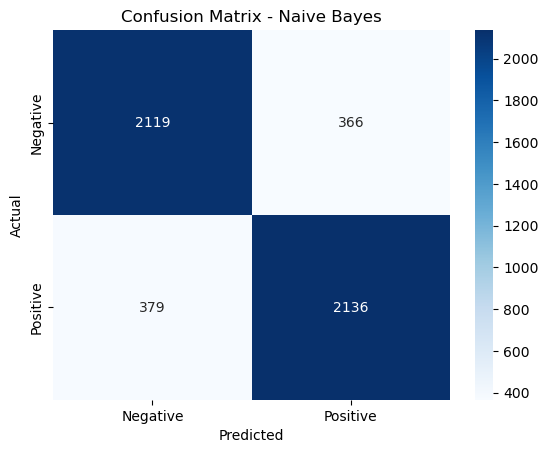

In [13]:
# Confusion Matrix for Naive Bayes
conf_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


In [19]:
import pickle
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [20]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.
